# Notebook 3

Ce notebook est consacré à l'apprentissage supervisé d'un modèle permettant de classifier à partir des images.

# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import time

from PIL import Image
from matplotlib.image import imread


#sklearn
from sklearn import preprocessing
from sklearn import cluster
from sklearn import manifold, decomposition
from sklearn import metrics
from sklearn.model_selection import train_test_split

#Keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from plot_keras_history import show_history, plot_history
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.metrics import Precision, Accuracy

In [2]:
df = pd.read_csv("for_notebook_2.csv")
df.head()

,image,target
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


In [3]:
#Pré-création d'un jeu de test
X = df["image"]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y, test_size = 0.1, random_state = 5)

df_test = pd.DataFrame(X_test)
df_test["target"] = y_test
df_test = df_test.reset_index(drop=True)

df_train_val = pd.DataFrame(X_train)
df_train_val["target"] = y_train
df_train_val = df_train_val.reset_index(drop=True)
df_train_val.shape

(945, 2)

In [4]:
#Pour le notebook de séparation des images
df_train_val.to_csv('df_train.csv', index_label = False)
df_test.to_csv('df_test.csv', index_label = False)

In [5]:
path = "Flipkart/Images/"

# 2. Préparation des images pour le modèle

## 2.1 Préparation initiale

In [6]:
def image_prep_vgg(df) :
    """
    gets the images from path, makes them 224x224 for VGG16 input, and returns them in an array
    """
    prepared_images = []
    for image_num in range(len(df['image'])) :
        img = (load_img(
            path + df['image'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

X = image_prep_vgg(df_train_val)
X_test = image_prep_vgg(df_test)

C:\Users\Yann\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [7]:
labelencoder = preprocessing.LabelEncoder()
df_train_val["label"] = labelencoder.fit_transform(df_train_val["target"])
df_test["label"] = labelencoder.fit_transform(df_test["target"])
df_test.head(10)

,image,target,label
0,553aa0252537751d153e7c50029f0242.jpg,Watches,6
1,a4951eb41979fe482879f777c8f21d2b.jpg,Home Decor & Festive Needs,3
2,57578c1e6ec61a880a6f3f971f5f77b8.jpg,Home Decor & Festive Needs,3
3,328b66226952d8733c0c48295fae1108.jpg,Kitchen & Dining,5
4,edec3bb5df9c4bc618752e94532bb36e.jpg,Home Decor & Festive Needs,3
5,3847353a4b8de1efc504d589aea74ffe.jpg,Kitchen & Dining,5
6,17611e6e94d73ef376834e5c6ee03dde.jpg,Home Decor & Festive Needs,3
7,189fa66a5fa6f08d2802a62ecf0be298.jpg,Watches,6
8,acd2f21d63ac0bbed4d52e6010d9460b.jpg,Kitchen & Dining,5
9,4f708bc74c4d29b2967dc38a1f5ae6d5.jpg,Computers,2


In [8]:
#Je m'assure que le LabelEncoding affiche les mêmes labels pour les deux dataframes
df_train_val.head(10)

,image,target,label
0,798346b99002495667bb87626d33b99c.jpg,Home Decor & Festive Needs,3
1,bba68d75eff1b7b5eef7f6c1c68f2227.jpg,Home Furnishing,4
2,146b0d570d5ab4e27629d48533b7680d.jpg,Computers,2
3,fa2e5f01bbb642c49e4b2e19d2b39dcf.jpg,Beauty and Personal Care,1
4,9a02f44389bda4c60e7dc23947dbca58.jpg,Beauty and Personal Care,1
5,3b465b02720ef7c930cb2e065a8fc05d.jpg,Baby Care,0
6,9ba898ecb77ab5a6799c8b047c6b6008.jpg,Kitchen & Dining,5
7,9a993e1b59649c93f667d38227325066.jpg,Computers,2
8,b4d35b6536b623c83b293eb3a1c02bba.jpg,Computers,2
9,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0


In [9]:
y_train_val = to_categorical(df_train_val["label"])
y_test = to_categorical(df_test["label"])

X.shape

(945, 224, 224, 3)

## 2.2 Jeux d'entraînement / validation / test

Ayant assez peu de données, je vais séparer avec 80% / 10% / 10% des données

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y_train_val, stratify = y_train_val, test_size = 1/9, random_state = 8)

X_train.shape

(840, 224, 224, 3)

In [11]:
X_test.shape

(105, 224, 224, 3)

In [12]:
X_val.shape

(105, 224, 224, 3)

Très bien. mes données sont maintenant bien séparées et prétraitées, on va pouvoir passer à la suite.

# 3. Premier modèle

## 3.1 Construction du modèle

Pour ma première tentative, je vais réutiliser le modèle pré-entraîné VGG16, mais cette fois-ci (par rapport au non supervisé du notebook précédent), je vais réentraîner les couches de sortie sur mes données.

In [13]:
#Je récupère la fonction en exemple, que je teste quelques fois afin d'ajuster les paramètres
def create_model_fct() :
    """
    crates the model with Transfer Learning. We get the weights from VGG16, then 
    we train a way less complex model on our data to get our predictions.
    """
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    # x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [14]:
model1 = create_model_fct()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Ensuite, comme je n'ai qu'assez peu de données, j'ai peur de l'overfitting malgré les précautions déjà prises.
Cela se traduirait par un nombre trop important d'epochs, et donc un apprentissage trop fréquent sur les mêmes données.

Pour prendre cela en compte, on va stocker le meilleur résultat, de manière à pouvoir le retrouver même une fois écrasé par la suite de l'apprentissage du modèle.

In [15]:
# Création du callback
model1_save_path = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

## 3.2 Entraînement et évaluation du modèle

In [16]:
#On entraîne le modèle avec les données d'entraînement et de validation
t1 = time.time()

history1 = model1.fit(X_train,
                      y_train, 
                      epochs=50, 
                      batch_size=64, 
                      callbacks=callbacks_list, 
                      validation_data=(X_val, y_val), 
                      verbose=1)

duration1=time.time()-t1
print("temps d'entrainement' : ", "%15.2f" % duration1, "secondes")

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 3.5224 - accuracy: 0.5667
Epoch 1: val_loss improved from inf to 2.29905, saving model to .\model1_best_weights.h5
14/14 [==============================] - 45s 3s/step - loss: 3.5224 - accuracy: 0.5667 - val_loss: 2.2991 - val_accuracy: 0.6000
Epoch 2/50


C:\Users\Yann\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - ETA: 0s - loss: 0.8857 - accuracy: 0.8214
Epoch 2: val_loss improved from 2.29905 to 2.26731, saving model to .\model1_best_weights.h5
14/14 [==============================] - 47s 3s/step - loss: 0.8857 - accuracy: 0.8214 - val_loss: 2.2673 - val_accuracy: 0.6762
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.4666 - accuracy: 0.8917
Epoch 3: val_loss improved from 2.26731 to 1.44946, saving model to .\model1_best_weights.h5
14/14 [==============================] - 47s 3s/step - loss: 0.4666 - accuracy: 0.8917 - val_loss: 1.4495 - val_accuracy: 0.7143
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.9429
Epoch 4: val_loss did not improve from 1.44946
14/14 [==============================] - 47s 3s/step - loss: 0.2057 - accuracy: 0.9429 - val_loss: 1.7479 - val_accuracy: 0.7143
Epoch 5/50
14/14 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9548
Epoch 5: val_lo

In [17]:
# Score du dernier epoch
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)

27/27 [==============================] - 43s 2s/step - loss: 0.0011 - accuracy: 1.0000

4/4 [==============================] - 5s 1s/step - loss: 1.3765 - accuracy: 0.7714


In [18]:
# Score de l'epoch optimal
model1.load_weights(model1_save_path)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss_1, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.7619
Test Accuracy       :  0.8286


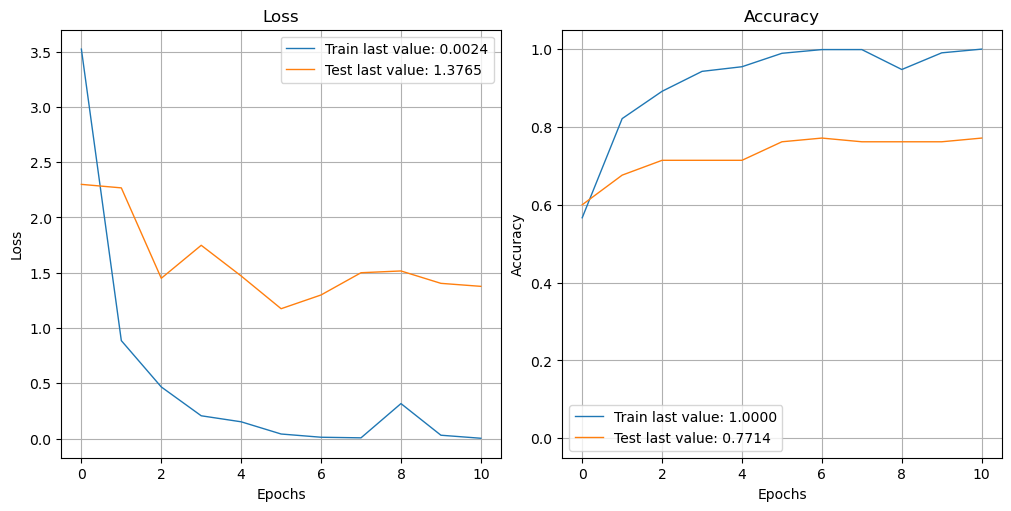

In [19]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

## 3.3 Matrice de confusion

In [20]:
y_test_num_1 = np.argmax(y_test, axis=1)
y_test_pred_1 = np.argmax(model1.predict(X_test), axis=1)
conf_mat = metrics.confusion_matrix(y_test_num_1, y_test_pred_1)
print(conf_mat)

4/4 [==============================] - 5s 1s/step
[[12  1  0  1  1  0  0]
 [ 0 14  0  0  0  0  1]
 [ 0  0 14  1  0  0  0]
 [ 3  0  0  7  1  4  0]
 [ 2  0  0  0 12  1  0]
 [ 0  0  0  1  0 13  1]
 [ 0  0  0  0  0  0 15]]


In [21]:
# Je reprends la fonction du notebook précédent
def conf_mat_transform(y_true,y_pred) :
    """
    met la matrice de confusion "dans l'ordre" (avec la diagonale dominante)
    """
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [22]:
y_test_pred_transform_1 = conf_mat_transform(y_test_num_1, y_test_pred_1)
conf_mat = metrics.confusion_matrix(y_test_num_1, y_test_pred_transform_1)
conf_mat

Correspondance des clusters :  [0 1 2 3 4 5 6]


array([[12,  1,  0,  1,  1,  0,  0],
       [ 0, 14,  0,  0,  0,  0,  1],
       [ 0,  0, 14,  1,  0,  0,  0],
       [ 3,  0,  0,  7,  1,  4,  0],
       [ 2,  0,  0,  0, 12,  1,  0],
       [ 0,  0,  0,  1,  0, 13,  1],
       [ 0,  0,  0,  0,  0,  0, 15]], dtype=int64)

<AxesSubplot:>

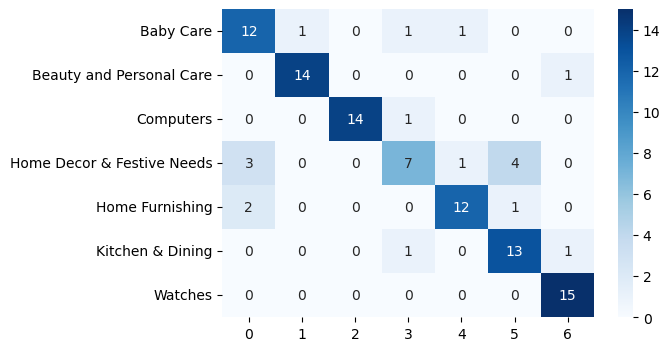

In [23]:
list_labels = ["Baby Care","Beauty and Personal Care","Computers","Home Decor & Festive Needs","Home Furnishing","Kitchen & Dining","Watches"]

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

Ce n'est pas encore parfait, mais on a une nette amélioration par rapport au non supervisé.

Essayons maintenant avec la data augmentation.

# 4. Deuxième modèle (le premier + data augmentation avec ImageDataGenerator)

Globalement, on va procéder exactement de la même manière. Ce qui change, ce sont nos données. En effet, on en a assez peu, et on va utiliser la data augmentation pour artificiellement augmenter leur nombre.

A noter que ImageDataGenerator est noté comme "deprecated", et on utilisera donc une autre approche ensuite.

## 4.1 Séparation des données et data augmentation

In [24]:
def data_flow_fct(df, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(df,
                                            directory=path,
                                            x_col='image',
                                            y_col='target',
                                            weight_col=None, 
                                            target_size=(224, 224),
                                            classes=None, 
                                            class_mode='categorical',
                                            batch_size=1, 
                                            shuffle=False, 
                                            seed=2,
                                            subset=data_type,
                                            save_to_dir = path + '/Augmented'
                                            )
    return data_flow

In [25]:
datagen_train = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=1/9,
                                    preprocessing_function=preprocess_input
                                  )

train_flow = data_flow_fct(df_train_val, datagen_train, data_type='training')
val_flow = data_flow_fct(df_train_val, datagen_train, data_type='validation')

#Pour le jeu de test, pas besoin de faire de la data augmentation
datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_test, datagen_test, data_type=None)


Found 840 validated image filenames belonging to 7 classes.
Found 105 validated image filenames belonging to 7 classes.
Found 105 validated image filenames belonging to 7 classes.


In [26]:
test_flow.__len__()

105

## 4.2 Création du modèle

In [27]:
#Modèle numéro 2 : le même que le premier.
model2 = create_model_fct()

#Comme pour le premier modèle, on créé un callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## 4.3 Entraînement et évaluation du modèle

In [28]:
#On entraîne le modèle avec les données d'entraînement et de validation
t2 = time.time()

history2 = model2.fit(train_flow, 
                      epochs=50, 
                      batch_size=32, 
                      callbacks=callbacks_list, 
                      validation_data=val_flow, 
                      verbose=1)

duration2=time.time()-t2
print("temps d'entrainement' : ", "%15.2f" % duration2, "secondes")

Epoch 1/50


C:\Users\Yann\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
C:\Users\Yann\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


717/840 [========================>.....] - ETA: 8s - loss: 2.4556 - accuracy: 0.6332

C:\Users\Yann\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


840/840 [==============================] - ETA: 0s - loss: 2.4235 - accuracy: 0.6417
Epoch 1: val_loss improved from inf to 1.76762, saving model to .\model2_best_weights.h5
840/840 [==============================] - 66s 78ms/step - loss: 2.4235 - accuracy: 0.6417 - val_loss: 1.7676 - val_accuracy: 0.7238
Epoch 2/50
  1/840 [..............................] - ETA: 1:17 - loss: 1.1206e-05 - accuracy: 1.0000

C:\Users\Yann\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


840/840 [==============================] - ETA: 0s - loss: 1.2066 - accuracy: 0.7810
Epoch 2: val_loss improved from 1.76762 to 1.57758, saving model to .\model2_best_weights.h5
840/840 [==============================] - 66s 78ms/step - loss: 1.2066 - accuracy: 0.7810 - val_loss: 1.5776 - val_accuracy: 0.7619
Epoch 3/50
840/840 [==============================] - ETA: 0s - loss: 0.8751 - accuracy: 0.8298
Epoch 3: val_loss did not improve from 1.57758
840/840 [==============================] - 66s 78ms/step - loss: 0.8751 - accuracy: 0.8298 - val_loss: 1.9428 - val_accuracy: 0.7619
Epoch 4/50
840/840 [==============================] - ETA: 0s - loss: 0.8201 - accuracy: 0.8619
Epoch 4: val_loss did not improve from 1.57758
840/840 [==============================] - 67s 80ms/step - loss: 0.8201 - accuracy: 0.8619 - val_loss: 2.3266 - val_accuracy: 0.7619
Epoch 5/50
840/840 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.8845
Epoch 5: val_loss did not improve from 1.

In [29]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation accuracy :  {:.4f}".format(accuracy))

840/840 [==============================] - 57s 68ms/step - loss: 0.2742 - accuracy: 0.9405
Training accuracy   : 0.9405

105/105 [==============================] - 7s 68ms/step - loss: 2.5775 - accuracy: 0.7429
Validation accuracy :  0.7429


In [30]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation accuracy :  {:.4f}".format(accuracy))

loss_2, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test accuracy       :  {:.4f}".format(accuracy))

Validation accuracy :  0.7524
Test accuracy       :  0.7429


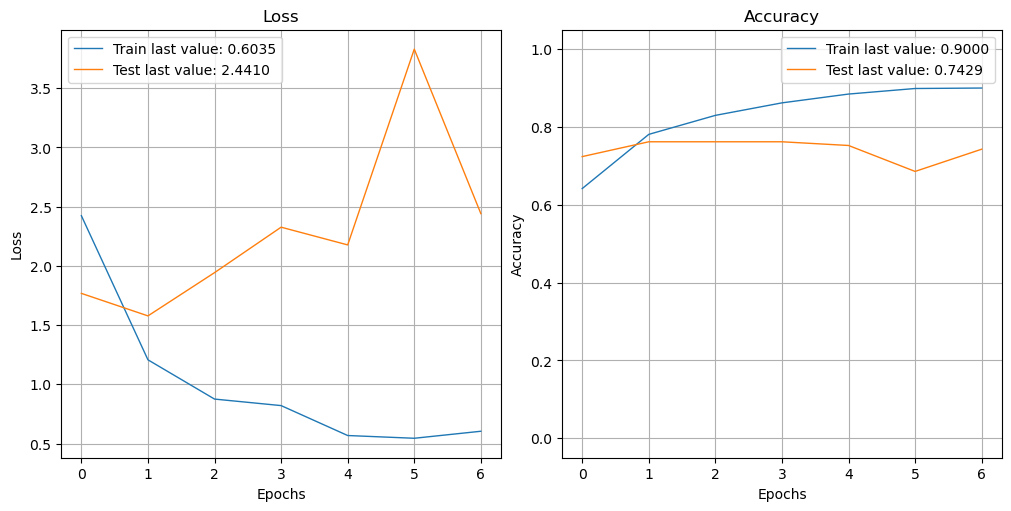

In [31]:
# history plot
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

# 4.4 Matrice de confusion

In [32]:
y_test_num_2 = np.argmax(y_test, axis=1)
y_test_pred_2 = np.argmax(model2.predict(X_test), axis=1)

y_test_pred_transform_2 = conf_mat_transform(y_test_num_2, y_test_pred_2)
conf_mat = metrics.confusion_matrix(y_test_num_2, y_test_pred_transform_2)
conf_mat

4/4 [==============================] - 5s 1s/step
Correspondance des clusters :  [0 1 2 3 4 5 6]


array([[ 8,  1,  0,  2,  3,  1,  0],
       [ 0, 11,  0,  1,  0,  3,  0],
       [ 0,  0,  9,  1,  0,  5,  0],
       [ 1,  1,  0,  8,  2,  3,  0],
       [ 0,  0,  0,  1, 13,  1,  0],
       [ 0,  0,  0,  0,  0, 15,  0],
       [ 0,  0,  0,  1,  0,  0, 14]], dtype=int64)

<AxesSubplot:>

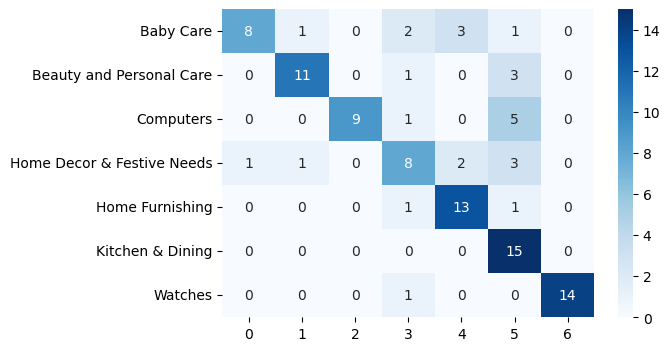

In [33]:
list_labels = ["Baby Care","Beauty and Personal Care","Computers","Home Decor & Festive Needs","Home Furnishing","Kitchen & Dining","Watches"]

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# 5. Approche par dataset

Comme mentionné précédemment, ImageDataGenerator est noté comme "deprecated". La nouvelle manière de faire préconisée est une approche par Datasets.

## 5.0 Souci structurel

Jusqu'ici, je n'ai jamais touché à la "structure" de mes images, c'est-à-dire qu'elles sont toutes rangées au même endroit, dans le dossier Flipkart/Images/.

Or, pour utiliser la fonction image_dataset_from_directory, j'ai besoin d'avoir :
- un dossier "train" et un "test" (pas complètement nécessaire mais ça me facilitera la tâche)
- dans chacun d'entre eux, 7 sous-dossiers : un pour chaque catégorie.

Pour éviter de trop charger ce notebook en particulier, j'ai choisi d'effectuer cette modification via un autre notebook, court et concis.

## 5.1 Création des datasets

In [34]:
path_train = 'Flipkart/Images_Train/'

dataset_train, dataset_val = image_dataset_from_directory(path_train,
                                                          labels = 'inferred',
                                                          label_mode = 'categorical',
                                                          batch_size = 32,
                                                          image_size = (224,224),
                                                          shuffle = True,
                                                          seed = 13,
                                                          validation_split = 1/9,
                                                          subset = 'both'
                                                         )

Found 945 files belonging to 7 classes.
Using 840 files for training.
Using 105 files for validation.


In [35]:
path_test = 'Flipkart/Images_Test/'

dataset_test = image_dataset_from_directory(path_test,
                                            labels = 'inferred',
                                            label_mode = 'categorical',
                                            batch_size = 32,
                                            image_size = (224,224),
                                            shuffle = False
                                            )

Found 105 files belonging to 7 classes.


## 5.2 Utilisation des datasets / Création du modèle

L'avantage, c'est qu'on va maintenant pouvoir utiliser facilement les fonctions de Keras trouvables ici :
https://www.tensorflow.org/tutorials/images/data_augmentation?hl=fr

Ces fonctions vont nous servir à faire de la data augmentation sans avoir besoin du ImageDataGenerator :

In [36]:
def create_model3_fct():
    """
    Same function as create_model_fct, but we use data augmentation first
    """
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal_and_vertical", input_shape=(224, 224, 3)),
        RandomRotation(0.2),
        # RandomZoom(0.1),
        Rescaling(1./127.5, offset=-1)
      ])
    
    # Récupération modèle pré-entraîné (comme pour create_model_fct)
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False
        
    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                # Dropout(0.5),
                Dense(7, activation='softmax')
                ])
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [37]:
model3 = create_model3_fct()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 14847815 (56.64 MB)
Trainable params: 133127 (520.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_______

In [38]:
# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

## 5.3 Entraînement et évaluation du modèle

A partir d'ici, c'est la même chose que pour les deux précédents modèles.

In [39]:
t3 = time.time()

history3 = model3.fit(dataset_train,
                      validation_data=dataset_val,
                      batch_size=32,
                      epochs=50,
                      callbacks=callbacks_list,
                      verbose=1)

duration3=time.time()-t3
print("temps d'entrainement' : ", "%15.2f" % duration3, "secondes")

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.6413 - accuracy: 0.4179
Epoch 1: val_loss improved from inf to 1.19997, saving model to .\model3_best_weights.h5
27/27 [==============================] - 51s 2s/step - loss: 1.6413 - accuracy: 0.4179 - val_loss: 1.2000 - val_accuracy: 0.6952
Epoch 2/50


C:\Users\Yann\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 1.1356 - accuracy: 0.6571
Epoch 2: val_loss improved from 1.19997 to 0.93055, saving model to .\model3_best_weights.h5
27/27 [==============================] - 53s 2s/step - loss: 1.1356 - accuracy: 0.6571 - val_loss: 0.9306 - val_accuracy: 0.7238
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.9702 - accuracy: 0.6631
Epoch 3: val_loss improved from 0.93055 to 0.83392, saving model to .\model3_best_weights.h5
27/27 [==============================] - 54s 2s/step - loss: 0.9702 - accuracy: 0.6631 - val_loss: 0.8339 - val_accuracy: 0.7524
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.8838 - accuracy: 0.7286
Epoch 4: val_loss improved from 0.83392 to 0.79005, saving model to .\model3_best_weights.h5
27/27 [==============================] - 52s 2s/step - loss: 0.8838 - accuracy: 0.7286 - val_loss: 0.7900 - val_accuracy: 0.7810
Epoch 5/50
27/27 [==============================] - ETA: 0s - l

In [40]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation accuracy :  {:.4f}".format(accuracy))

27/27 [==============================] - 45s 2s/step - loss: 0.4333 - accuracy: 0.8583
Training accuracy   : 0.8583

4/4 [==============================] - 6s 1s/step - loss: 0.7290 - accuracy: 0.8095
Validation accuracy :  0.8095


In [41]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation accuracy :  {:.4f}".format(accuracy))

loss_3, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test accuracy       :  {:.4f}".format(accuracy))


Validation accuracy :  0.8000
Test accuracy       :  0.7905


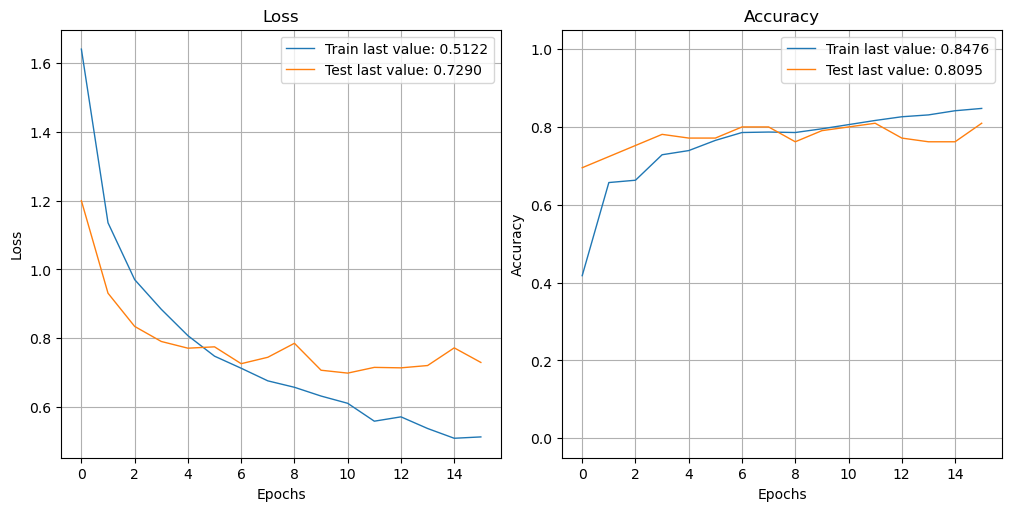

In [42]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## 5.4 Matrice de confusion

Pour commencer, jene peux pas utiliser y_test comme précédemment, à cause de la construction des datasets qui a été effectuée différemment (en triant les dossiers) cette fois-ci.

Je peux y remédier ainsi.

In [43]:
y_test_datasets = np.concatenate([y for x, y in dataset_test], axis=0)
# Je vérifie le bon fonctionnement (en commenté parce que l'array retourné est long)
# y_test_datasets 

In [44]:
y_test_num_3 = np.argmax(y_test_datasets, axis=1)
y_test_pred_3 = np.argmax(model3.predict(dataset_test), axis=1)

y_test_pred_transform_3 = conf_mat_transform(y_test_num_3, y_test_pred_3)
conf_mat = metrics.confusion_matrix(y_test_num_3, y_test_pred_transform_3)
conf_mat

4/4 [==============================] - 5s 1s/step
Correspondance des clusters :  [0 1 2 3 4 5 6]


array([[ 9,  0,  0,  3,  2,  1,  0],
       [ 0, 12,  1,  1,  0,  1,  0],
       [ 0,  1, 13,  1,  0,  0,  0],
       [ 1,  0,  3,  9,  0,  2,  0],
       [ 1,  0,  0,  1, 12,  1,  0],
       [ 1,  0,  1,  0,  0, 13,  0],
       [ 0,  0,  0,  0,  0,  0, 15]], dtype=int64)

<AxesSubplot:>

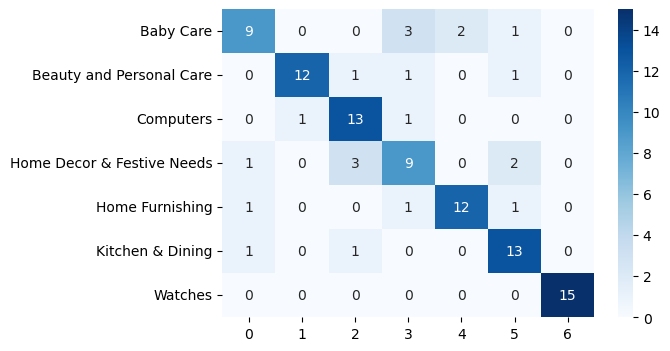

In [45]:
list_labels = ["Baby Care","Beauty and Personal Care","Computers","Home Decor & Festive Needs","Home Furnishing","Kitchen & Dining","Watches"]

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# 6. Conclusions

## 6.1 Premières conclusions

Je n'ai pas encore terminé mon étude, mais je peux déjà m'exprimer sur ce que l'on observe jusqu'ici.

Disclaimer : je sais que l'accuracy n'est pas nécessairement la meilleure métrique à propos d'une classification avec plus de deux classes. Je vais donc prendre des pincettes quant à ces premières conclusions. En revanche, l'observation des matrices de confusion nous permet de détailler nos observations un peu plus en profondeur.


- Globalement, les trois modèles testés dans ce notebook semblent très prometteurs. Avec un jeu de données aussi peu fourni, la classification est satisfaisante. Suffisamment satisfaisante pour être utilisée directement par "Place de marché" ? Non. Mais suffisament satisfaisante pour vouloir l'entraîner sur un jeu de données plus important avant une future implémentation.

- Plus précisément, certaines de nos catégories sont très bien prédites. D'autres le sont beaucoup plus difficilement. Cela est en grande majorité dû au manque de données. En effet, la catégorie "Watches", qui est toujours très bien prédite, ne comporte quasiement que des images de montres. Certaines sont des radio-réveils, mais cela reste marginal. En revanche, la catégorie "Home Decor & Festive Needs", par exemple, est rarement bien prédite (on a tout de même une précision non ridicule). Cela est dû au fait que les objets rentrant dans cette catégorie sont beaucoup plus variés, et certains sont même uniques dans notre jeu de données. Difficile, donc, d'entraîner une IA pour les reconnaître, aussi performante soit-elle.

- Pour comparer mes trois modèles testés ici, utiliser l'accuracy me semble léger. Tout d'abord elle varie peu entre ces modèles, et de plus elle est trop "vague" pour être exploitable solidement en tant que comparaison. En revanche, on remarque que la "loss" (entropie croisée) est nettement plus faible (et donc meilleure) pour notre dernier modèle. C'est donc plutôt celui-ci qui va nous intéresser pour l'éventuelle suite des événements.

## 6.2 Précision des modèles

Je vais à présent calculer la précision de mes modèles pour deux raisons :

- Je souhaite renforcer mes observations.

- Je me place dans l'hypothèse où je ne peux pas obtenir de nouvelles données. Dans ce cas, je ne me vois pas implémenter mon modèle tel quel, parce qu'il n'est pas suffisamment performant. En revanche, j'aimerais déjà dire que je lui fais confiance pour certaines catégories, et éventuellement envisager une implémentation partielle. Pour cette raison, je veux savoir pour quelles catégories il est performant lorsqu'il la prédit. Autrement dit, s'il prédit "Baby Care", je veux qu'il ait juste. C'est pourquoi mon choix s'est porté sur la précision.

In [46]:
#Je récupère la précision sur chaque classe pour mes 3 modèles
precision3 = metrics.precision_score(y_test_num_3,y_test_pred_3, average = None)
precision3

array([0.75      , 0.92307692, 0.72222222, 0.6       , 0.85714286,
       0.72222222, 1.        ])

In [47]:
precision2 = metrics.precision_score(y_test_num_2,y_test_pred_2, average = None)
precision2

array([0.88888889, 0.84615385, 1.        , 0.57142857, 0.72222222,
       0.53571429, 1.        ])

In [48]:
precision1 = metrics.precision_score(y_test_num_1,y_test_pred_1, average = None)
precision1

array([0.70588235, 0.93333333, 1.        , 0.7       , 0.85714286,
       0.72222222, 0.88235294])

In [49]:
# Je construis un tableau pour une meilleure lisibilité
comparison_df = pd.DataFrame(columns=['Baby_Care_Precision',
                                      'Beauty_Precision',
                                      'Computers_Precision',
                                      'Decor_Precision',
                                      'Furnishing_Precision',
                                     'Kitchen Precision',
                                     'Watches Precision'],
                             index=['model1','model2','model3'])

comparison_df.loc['model1'] = precision1
comparison_df.loc['model2'] = precision2
comparison_df.loc['model3'] = precision3

In [50]:
comparison_df

,Baby_Care_Precision,Beauty_Precision,Computers_Precision,Decor_Precision,Furnishing_Precision,Kitchen Precision,Watches Precision
model1,0.705882,0.933333,1.0,0.7,0.857143,0.722222,0.882353
model2,0.888889,0.846154,1.0,0.571429,0.722222,0.535714,1.0
model3,0.75,0.923077,0.722222,0.6,0.857143,0.722222,1.0


En vérité, si je ne regarde que la précision (sur toutes les catégories), il est difficile de conclure quoi que ce soit. Premièrement, parce que les trois modèles ont une performance relativement similaire lorsqu'on regarde l'ensemble (La précision moyenne est l'accuracy). Deuxièmement, à cause de l'aléatoire dû à ma méthode d'apprentissage. En effet, le train_test_split opéré au départ pourrait être différent, et nous donner d'autres résultats. De plus, pour le dernier modèle, le "shuffle" effectué lors de la création du dataset est aussi un facteur de génération d'aléatoire, si je modifie sa "seed", j'aurai des résultats différents.

Pour avoir un tableau complet, je vais ajouter la "loss" et le temps d'entrainement.

In [51]:
comparison_df["loss"] = [loss_1, loss_2, loss_3]
comparison_df["training_time"] = [duration1, duration2, duration3]
comparison_df

,Baby_Care_Precision,Beauty_Precision,Computers_Precision,Decor_Precision,Furnishing_Precision,Kitchen Precision,Watches Precision,loss,training_time
model1,0.705882,0.933333,1.0,0.7,0.857143,0.722222,0.882353,1.054902,522.718118
model2,0.888889,0.846154,1.0,0.571429,0.722222,0.535714,1.0,1.564525,463.907020
model3,0.75,0.923077,0.722222,0.6,0.857143,0.722222,1.0,0.643752,845.261600


## 6.3 Dernières conclusions

Même si le temps d'entraînement est plus important pour le dernier modèle, il reste suffisamment raisonnable pour envisager de l'utiliser. D'autant qu'il est nettement plus performant sur la fonction de perte. C'est donc à mon sens le plus prometteur. Cela dit, si on veut bien nous donner un jeu de données suffisamment important, on n'aura peut-être plus besoin de data augmentation, et donc le modèle 1 sera adapté.

Il convient aussi de se rappeler qu'à l'origine, on avait en fait beaucoup plus de sous-catégories que les 7 retenues finalement. Toujours dans le cadre où on a si peu de données, il est totalement inenvisageable de prédire aussi loin.

On pourrait, s'il fallait vraiment tout optimiser avec ces données, également envisager de créer un modèle s'appuyant à la fois sur l'image et le texte. 

Pour le reste des conclusions, elles sont dans le paragraphe "Premières conclusions", légèrement plus haut.

Merci pour votre lecture !